# **Machine Learning CEP**

**Group: G2**

Roll no:

1. Farzam Nasir (CS-22137)
2. Abdul Ahad (CS-22139)
3. Hamza Ali (CS-22146)


# ***Importing necessary libraries***


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc,precision_score,f1_score,recall_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import normalize,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
!pip install scikeras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output
import torch
import torch.nn as nn

# ***Data Analysis***

**Analyzing the dataset and checking the feature values.**

## Loading the dataset

In [ ]:
data = pd.read_csv("weatherHistory.csv")

In [ ]:
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


# ***Feature Engineering***

**It is observed that there are 53% null values in Precip Type feature.**

In [ ]:
data.apply(pd.isnull).sum() # checking the null values
data.apply(pd.isnull).sum()/data.shape[0]*100 #  53% data is null for precip

,0
Formatted Date,0.000000
Summary,0.000000
Precip Type,0.536012
Temperature (C),0.000000
Apparent Temperature (C),0.000000
Humidity,0.000000
Wind Speed (km/h),0.000000
Wind Bearing (degrees),0.000000
Visibility (km),0.000000
Loud Cover,0.000000


In [ ]:
print(data.shape) # basically it is a tuple show rows and column :)

(96453, 12)


In [ ]:
data["Precip Type"].unique()

array(['rain', 'snow', nan], dtype=object)

**Fill missing values in the 'Precip Type' column based on temperature. If Temperature > 0°C, assume 'rain'; otherwise, assume 'snow'.**

In [ ]:
data['Precip Type'] = data['Precip Type'].fillna(
    data.apply(lambda row: 'rain' if row['Temperature (C)'] > 0 else 'snow', axis=1)
)

In [ ]:
data.apply(pd.isnull).sum()

,0
Formatted Date,0
Summary,0
Precip Type,0
Temperature (C),0
Apparent Temperature (C),0
Humidity,0
Wind Speed (km/h),0
Wind Bearing (degrees),0
Visibility (km),0
Loud Cover,0


In [ ]:
data["Precip Type"].unique()

array(['rain', 'snow'], dtype=object)

## **Converting time series data to appropriate format**

Since we're working with time series data, we extract and engineer features that help reveal hidden temporal patterns.<br/>
We begin by converting the 'Formatted Date' column to datetime format and then extract several time-based features.<br/>

Hour: Hour of the day (0–23)

Day_of_week: Day of the week (0 = Monday, 6 = Sunday)

Month: Month of the year (1–12)

We calculate the season from the month using integer division, where:

1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall

Time features like Hour and Month are cyclical. For example, hour 23 and hour 0 are next to each other in time, but numerically distant. To handle this, we use sine and cosine transformations to encode them in a way that preserves their circular nature. This encoding helps machine learning models better understand time-based patterns.


In [ ]:
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data['Hour'] = data['Formatted Date'].dt.hour
data['Day_of_week'] = data['Formatted Date'].dt.dayofweek
data['Month'] = data['Formatted Date'].dt.month
data['Season'] = (data['Month'] % 12 + 3) // 3
data['Is_weekend'] = (data['Day_of_week'] >= 5).astype(int)

data['Hour_sin'] = np.sin(2 * np.pi * data['Hour']/24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour']/24)
data['Month_sin'] = np.sin(2 * np.pi * data['Month']/12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month']/12)

data['Temp_Humidity'] = data['Temperature (C)'] * data['Humidity']
data['Wind_Pressure'] = data['Wind Speed (km/h)'] * data['Pressure (millibars)']

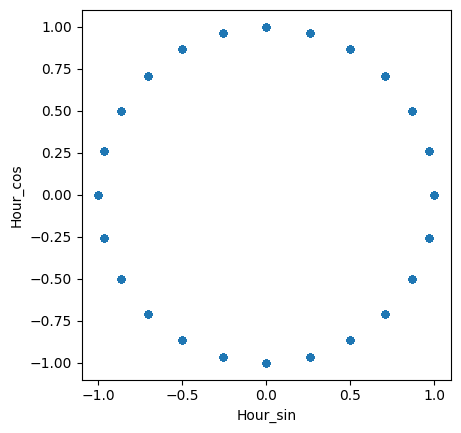

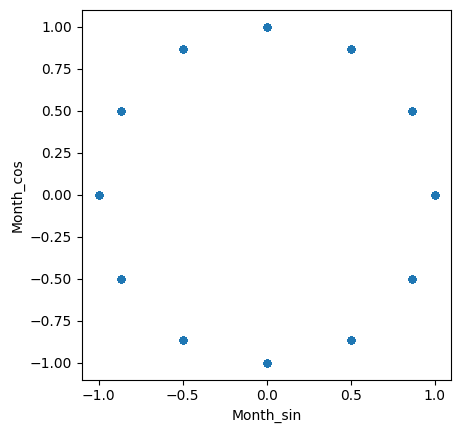

In [ ]:
# Proving that hour, months and days of the week are now in cyclical form
data.plot.scatter('Hour_sin', 'Hour_cos').set_aspect('equal')
data.plot.scatter('Month_sin', 'Month_cos').set_aspect('equal')

In [ ]:
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,...,Day_of_week,Month,Season,Is_weekend,Hour_sin,Hour_cos,Month_sin,Month_cos,Temp_Humidity,Wind_Pressure
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,...,4,3,2,0,-0.500000,0.866025,1.000000,6.123234e-17,8.430278,14333.331061
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,...,4,3,2,0,-0.258819,0.965926,1.000000,6.123234e-17,8.045778,14487.555698
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,...,5,4,2,1,0.000000,1.000000,0.866025,-5.000000e-01,8.346222,3991.018696
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,...,5,4,2,1,0.258819,0.965926,0.866025,-5.000000e-01,6.879778,14335.040076
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,...,5,4,2,1,0.500000,0.866025,0.866025,-5.000000e-01,7.267111,11226.946346


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               96453 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

**The Daily Summary column in the dataset contains verbose textual descriptions of weather conditions. To make these summaries more consistent and model-friendly, we define a function to categorize them into simplified weather types.**

In [ ]:
def simplify_daily_summary(text):
    if 'cloudy' in text.lower():
        return 'Cloudy'
    elif 'breezy' in text.lower() or 'windy' in text.lower():
        return 'Windy'
    elif 'rain' in text.lower() or 'drizzle' in text.lower():
        return 'Rainy'
    elif 'clear' in text.lower() or 'dry' in text.lower():
        return 'Clear/Dry'
    else:
        return 'Other'

data['Daily Summary'] = data['Daily Summary'].apply(simplify_daily_summary)

**Drop these columns [''Formatted Date', 'Loud Cover', 'Apparent Temperature (C)']**

In [ ]:
data = data.drop([
    'Formatted Date', 'Loud Cover',
    'Apparent Temperature (C)'
], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Summary                 96453 non-null  object 
 1   Precip Type             96453 non-null  object 
 2   Temperature (C)         96453 non-null  float64
 3   Humidity                96453 non-null  float64
 4   Wind Speed (km/h)       96453 non-null  float64
 5   Wind Bearing (degrees)  96453 non-null  float64
 6   Visibility (km)         96453 non-null  float64
 7   Pressure (millibars)    96453 non-null  float64
 8   Daily Summary           96453 non-null  object 
 9   Hour                    96453 non-null  int32  
 10  Day_of_week             96453 non-null  int32  
 11  Month                   96453 non-null  int32  
 12  Season                  96453 non-null  int32  
 13  Is_weekend              96453 non-null  int64  
 14  Hour_sin                96453 non-null

In [ ]:
data["Daily Summary"].unique()

array(['Cloudy', 'Other', 'Windy', 'Clear/Dry', 'Rainy'], dtype=object)

**Performing label encoding on categorical values**

In [ ]:
data["Precip Type"] = data["Precip Type"].replace(["snow","rain"],[0,1])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Summary                 96453 non-null  object 
 1   Precip Type             96453 non-null  int64  
 2   Temperature (C)         96453 non-null  float64
 3   Humidity                96453 non-null  float64
 4   Wind Speed (km/h)       96453 non-null  float64
 5   Wind Bearing (degrees)  96453 non-null  float64
 6   Visibility (km)         96453 non-null  float64
 7   Pressure (millibars)    96453 non-null  float64
 8   Daily Summary           96453 non-null  object 
 9   Hour                    96453 non-null  int32  
 10  Day_of_week             96453 non-null  int32  
 11  Month                   96453 non-null  int32  
 12  Season                  96453 non-null  int32  
 13  Is_weekend              96453 non-null  int64  
 14  Hour_sin                96453 non-null

**Performing One-Hot Encoding on Daily Summary Column**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_features = ['Daily Summary']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encodedFeatures = encoder.fit_transform(data[cat_features])
encodedDf = pd.DataFrame(encodedFeatures, columns=encoder.get_feature_names_out(cat_features))
data = pd.concat([data, encodedDf], axis=1).drop(cat_features, axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Summary                  96453 non-null  object 
 1   Precip Type              96453 non-null  int64  
 2   Temperature (C)          96453 non-null  float64
 3   Humidity                 96453 non-null  float64
 4   Wind Speed (km/h)        96453 non-null  float64
 5   Wind Bearing (degrees)   96453 non-null  float64
 6   Visibility (km)          96453 non-null  float64
 7   Pressure (millibars)     96453 non-null  float64
 8   Hour                     96453 non-null  int32  
 9   Day_of_week              96453 non-null  int32  
 10  Month                    96453 non-null  int32  
 11  Season                   96453 non-null  int32  
 12  Is_weekend               96453 non-null  int64  
 13  Hour_sin                 96453 non-null  float64
 14  Hour_cos              

## **Modifying Target Feature**

In [ ]:
data["Summary"].unique()

array(['Partly Cloudy', 'Mostly Cloudy', 'Overcast', 'Foggy',
       'Breezy and Mostly Cloudy', 'Clear', 'Breezy and Partly Cloudy',
       'Breezy and Overcast', 'Humid and Mostly Cloudy',
       'Humid and Partly Cloudy', 'Windy and Foggy', 'Windy and Overcast',
       'Breezy and Foggy', 'Windy and Partly Cloudy', 'Breezy',
       'Dry and Partly Cloudy', 'Windy and Mostly Cloudy',
       'Dangerously Windy and Partly Cloudy', 'Dry', 'Windy',
       'Humid and Overcast', 'Light Rain', 'Drizzle', 'Windy and Dry',
       'Dry and Mostly Cloudy', 'Breezy and Dry', 'Rain'], dtype=object)

**It is observed that there are 27 classes present in the dataset. But for better performance we reduce the number of classes upto 4.**

1. Cloudy
2. Windy
3. Clear/Dry
4. Rainy

**Simplifying the summary column by giving same labels to same meaning values.**

In [ ]:
labels = {
    'Partly Cloudy': 'Cloudy',
    'Mostly Cloudy': 'Cloudy',
    'Overcast': 'Cloudy',
    'Foggy': 'Cloudy',
    'Breezy and Mostly Cloudy': 'Windy',
    'Clear': 'Clear/Dry',
    'Breezy and Partly Cloudy': 'Windy',
    'Breezy and Overcast': 'Windy',
    'Humid and Mostly Cloudy': 'Clear/Dry',
    'Humid and Partly Cloudy': 'Clear/Dry',
    'Windy and Foggy': 'Windy',
    'Windy and Overcast': 'Windy',
    'Breezy and Foggy': 'Windy',
    'Windy and Partly Cloudy': 'Windy',
    'Breezy': 'Windy',
    'Dry and Partly Cloudy': 'Clear/Dry',
    'Windy and Mostly Cloudy': 'Windy',
    'Dangerously Windy and Partly Cloudy': 'Windy',
    'Dry': 'Clear/Dry',
    'Windy': 'Windy',
    'Humid and Overcast': 'Clear/Dry',
    'Light Rain': 'Rainy',
    'Drizzle': 'Rainy',
    'Windy and Dry': 'Windy',
    'Dry and Mostly Cloudy': 'Clear/Dry',
    'Breezy and Dry': 'Windy',
    'Rain': 'Rainy'
}

In [ ]:
data['Summary'] = data['Summary'].map(labels)

In [ ]:
data['Summary'].unique()

array(['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'], dtype=object)

## **Handling Data Imbalance**

In [ ]:
"""As you can see data is Imbalanced and baised so we need to handle this we
adjust some synthetic samples to minority class like SMOTE"""
data['Summary'].value_counts()

,count
Summary,
Cloudy,83572
Clear/Dry,11088
Windy,1681
Rainy,112


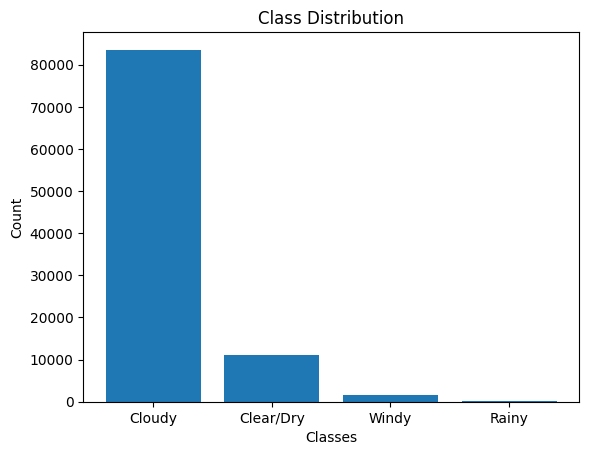

In [ ]:
count_class = data['Summary'].value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Cloudy', 'Clear/Dry', 'Windy', 'Rainy'])
plt.show()

**Label encoding on Summary column**

In [ ]:
"""Now lets do Integer encoding for target variable lessgoo"""
data['Summary'] = data['Summary'].replace(['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'],[0,1,2,3])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Summary                  96453 non-null  int64  
 1   Precip Type              96453 non-null  int64  
 2   Temperature (C)          96453 non-null  float64
 3   Humidity                 96453 non-null  float64
 4   Wind Speed (km/h)        96453 non-null  float64
 5   Wind Bearing (degrees)   96453 non-null  float64
 6   Visibility (km)          96453 non-null  float64
 7   Pressure (millibars)     96453 non-null  float64
 8   Hour                     96453 non-null  int32  
 9   Day_of_week              96453 non-null  int32  
 10  Month                    96453 non-null  int32  
 11  Season                   96453 non-null  int32  
 12  Is_weekend               96453 non-null  int64  
 13  Hour_sin                 96453 non-null  float64
 14  Hour_cos              

### **Performing Oversampling**

In [ ]:
X = data.drop('Summary', axis=1)
y = data['Summary']

In [ ]:
smote = SMOTE(random_state=42,k_neighbors=9)

In [ ]:
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
"""Now all classes samples are equal in frequency"""
y_resampled.value_counts()

,count
Summary,
0,83572
1,83572
2,83572
3,83572


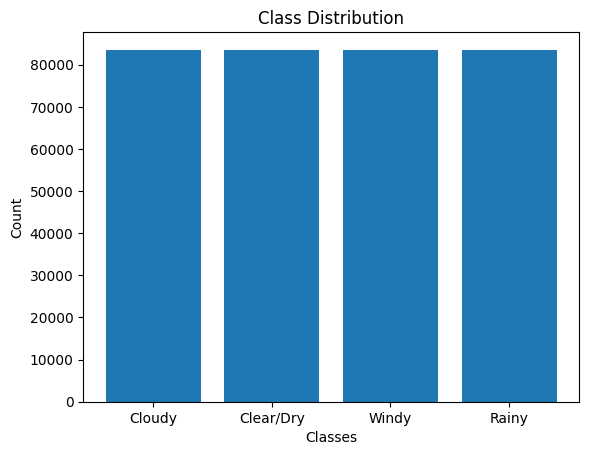

In [ ]:
count_class = y_resampled.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Cloudy', 'Clear/Dry', 'Windy', 'Rainy'])
plt.show()

## **Data Normalization**
**Scaling the data to bring values on similar scale.**

In [ ]:
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X.columns)

In [ ]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# ***Train Test Split (Ratio 80:20)***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

In [ ]:
columns = list(X_train.columns)
with open('columns.pkl', 'wb') as f:
    pickle.dump(columns, f)

In [ ]:
print(columns)

['Precip Type', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'Hour', 'Day_of_week', 'Month', 'Season', 'Is_weekend', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Temp_Humidity', 'Wind_Pressure', 'Daily Summary_Clear/Dry', 'Daily Summary_Cloudy', 'Daily Summary_Other', 'Daily Summary_Rainy', 'Daily Summary_Windy']


# ***Model Initialization and Evaluation***

## **Logistic Regression (Parametric Model)**

In [ ]:
regr = LogisticRegression(multi_class='multinomial',max_iter=2000,random_state=42,penalty='l2',C=0.1)

In [ ]:
model = regr.fit(X_train,y_train)

In [ ]:
import pickle
filename = 'lrmodel.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
ypred = model.predict(X_test)

In [ ]:
accuracy_score(ypred,y_test)

0.8700679051123276

In [ ]:
testaccuracy = model.score(X_test, y_test)
print("test accuracy",testaccuracy)

test accuracy 0.8700679051123276


In [ ]:
trainaccuracy = model.score(X_train, y_train)
print(trainaccuracy)

0.8701379800321579


## **KNearestneighbour (Non-Parametric Model)**

In [ ]:
NB = KNeighborsClassifier(n_neighbors=3,metric='minkowski',algorithm='brute')

In [ ]:
model2 = NB.fit(X_train,y_train)

In [ ]:
filename = 'KNNmodel.pkl'
pickle.dump(model2, open(filename, 'wb'))

In [ ]:
ypred = model2.predict(X_test)

In [ ]:
accuracy_score(ypred,y_test)

0.952870262347064

In [ ]:
testaccuracy = model2.score(X_test, y_test)
print("test accuracy",testaccuracy)

test accuracy 0.952870262347064


In [ ]:
trainaccuracy = model2.score(X_train, y_train)
print(trainaccuracy)

0.979785364394421


In [ ]:
print(confusion_matrix(ypred,y_test))

[[14812    10  1214     0]
 [  170 16882    53     0]
 [ 1687     7 15342     0]
 [   10     0     0 16671]]


## **Neural Network**

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [ ]:
print("Number of classes:", len(np.unique(y_train)))

Number of classes: 2


In [ ]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
print( y_train.shape)
print( y_train.shape[1])

(267430, 4)
4


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

I use categorical_crossentropy because my target variable is one hot encoded if it is encoded and integer then i would  use sparse

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Training the Artificial Neural Network

Epochs: Train for up to 50 iterations.

Batch Size: 256 samples per batch.

Validation Split: 20% of training data used for validation.

EarlyStopping: Stops training if validation performance doesn’t improve for 5 epochs and restores the best weights.

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8051 - loss: 0.4661 - val_accuracy: 0.9153 - val_loss: 0.1930
Epoch 2/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9044 - loss: 0.2208 - val_accuracy: 0.9306 - val_loss: 0.1612
Epoch 3/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9179 - loss: 0.1900 - val_accuracy: 0.9408 - val_loss: 0.1440
Epoch 4/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9256 - loss: 0.1745 - val_accuracy: 0.9431 - val_loss: 0.1360
Epoch 5/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9298 - loss: 0.1645 - val_accuracy: 0.9420 - val_loss: 0.1340
Epoch 6/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9319 - loss: 0.1579 - val_accuracy: 0.9479 - val_loss: 0.1234
Epoch 7/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9346 - loss: 0.1514 - val_accuracy: 0.9486 - val_loss: 0.1210
Epoch 8/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9367 - loss: 0.1471 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracyfor the test data is {test_acc:.2f}")

Test Accuracyfor the test data is 0.96


In [ ]:
model.save("NNmodel.h5")

Classification Report

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Cloudy', 'Windy', 'Clear/Dry', 'Rainy']
))

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

      Cloudy       0.88      0.96      0.92     16679
       Windy       1.00      1.00      1.00     16899
   Clear/Dry       0.96      0.87      0.91     16609
       Rainy       1.00      1.00      1.00     16671

    accuracy                           0.96     66858
   macro avg       0.96      0.96      0.96     66858
weighted avg       0.96      0.96      0.96     66858



In [ ]:
data.shape[1]

12

In [ ]:
""" Assuming y_test and y_pred are in multilabel-indicator format and then Calculate ROC AUC for each class
after that Compute micro-average ROC curve and ROC area Compute macro-average ROC curve and ROC area
then First aggregate all false positive rates hen interpolate all ROC curves at this points. Finally average it and compute AUC
"""

n_classes = y_test.shape[1]


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"ROC AUC for each class: {roc_auc}")
print(f"Micro-average ROC AUC: {roc_auc['micro']}")
print(f"Macro-average ROC AUC: {roc_auc['macro']}")

ROC AUC for each class: {0: np.float64(0.9745247429992939), 1: np.float64(0.9999585653489901), 2: np.float64(0.9757028272428666), 3: np.float64(0.9999608147789878), 'micro': np.float64(0.9936395822505071), 'macro': np.float64(0.9875418976352968)}
Micro-average ROC AUC: 0.9936395822505071
Macro-average ROC AUC: 0.9875418976352968


# ***Hyperparameter Tuning with GridSearchCV***

In [ ]:
param_grid_logistic = {'C': [0.01, 1, 100],'max_iter' : [1000,5000,10000]}
param_grid_knn = {'n_neighbors': [3, 5, 7], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
param_grid_nn = {'hidden_units': [16, 32, 64], 'learning_rate': [0.01, 0.001, 0.0001]}

In [ ]:
logistic = LogisticRegression()
grid_logistic = GridSearchCV(logistic, param_grid_logistic, cv=5)
grid_logistic.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 1, 100], 'max_iter': [1000, 5000, 10000]})

In [ ]:
evaluator_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
evaluator_knn.fit(X_train, y_train)

In [ ]:
def build_nn(units1=128, units2=64, units3=32,
             dropout1=0.3, dropout2=0.2, dropout3=0.2,
             learning_rate=0.001):
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout1),
        Dense(units2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout2),
        Dense(units3, activation='relu'),
        BatchNormalization(),
        Dropout(dropout3),
        Dense(y_train.shape[1] if y_train.ndim>1 else len(np.unique(y_train)), activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [ ]:
nn_clf = KerasClassifier(
    build_fn=build_nn,
    epochs=20,
    batch_size=256,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

In [ ]:
neuralNParams = {
    'units1': [64, 128],
    'units2': [32, 64],
    'units3': [16, 32],
    'dropout1': [0.2, 0.3],
    'dropout2': [0.2],
    'dropout3': [0.2],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [128, 256]

}

In [ ]:
models = {
    'LogisticRegression': grid_logistic.best_estimator_,
    'KNN': evaluator_knn.best_estimator_,
}

In [ ]:
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

results_df = pd.DataFrame(results)

In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,0.870621,0.870385,0.870621,0.870486
1,KNN,0.952870,0.952812,0.952870,0.952708


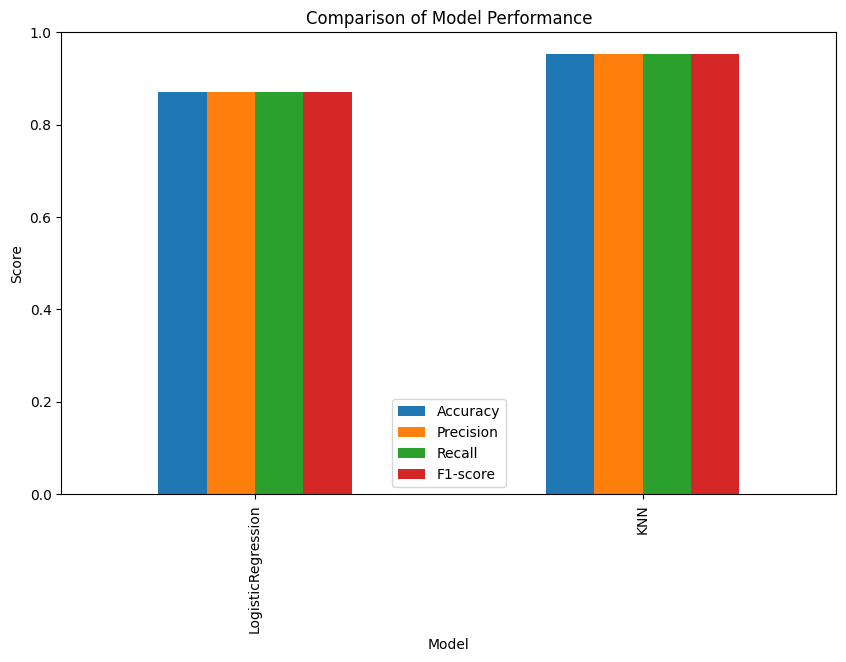

In [ ]:
def plot_metrics(df):
    df.set_index('Model', inplace=True)
    df.plot(kind='bar', figsize=(10,6), xlabel='Model', ylabel='Score', legend=True)
    plt.title('Comparison of Model Performance')
    plt.show()

plot_metrics(results_df.copy())

In [ ]:
X_test.to_csv('test.csv')

# ***Train Test Split Ratio (60:40)***

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_normalized, y_resampled, test_size=0.4, random_state=42)

## Logistic Regression

In [ ]:
# Initialize data structures to store results
logistic_results = []
knn_results = []
ann_results = []

In [ ]:
C_values = [0.01, 1, 100]
max_iters = [2000, 5000, 10000]

print("Logistic Regression Results")
for c, max_iter in zip(C_values, max_iters):
    model = LogisticRegression(multi_class='multinomial', random_state=42, C=c, max_iter=max_iter)
    model.fit(X_train_2, y_train_2)
    train_acc = model.score(X_train_2, y_train_2)
    test_pred = model.predict(X_test_2)
    test_acc = accuracy_score(y_test_2, test_pred)
    logistic_results.append({
        'C': c,
        'max_iter': max_iter,
        'train_acc': train_acc,
        'test_acc': test_acc
    })
    print(f"\nC={c}, max_iter={max_iter}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision (Macro): {precision_score(y_test_2, test_pred, average='macro'):.4f}")
    print(f"Recall (Macro):    {recall_score(y_test_2, test_pred, average='macro'):.4f}")
    print(f"F1 Score (Macro):  {f1_score(y_test_2, test_pred, average='macro'):.4f}")
    print("Classification Report",classification_report(y_test_2, test_pred))

Logistic Regression Results

C=0.01, max_iter=2000
Train Accuracy: 0.8675
Test Accuracy: 0.8683
Precision (Macro): 0.8675
Recall (Macro):    0.8683
F1 Score (Macro):  0.8679
Classification Report               precision    recall  f1-score   support

           0       0.74      0.73      0.74     33438
           1       0.98      1.00      0.99     33507
           2       0.75      0.75      0.75     33425
           3       1.00      0.99      0.99     33346

    accuracy                           0.87    133716
   macro avg       0.87      0.87      0.87    133716
weighted avg       0.87      0.87      0.87    133716


C=1, max_iter=5000
Train Accuracy: 0.8705
Test Accuracy: 0.8709
Precision (Macro): 0.8706
Recall (Macro):    0.8709
F1 Score (Macro):  0.8707
Classification Report               precision    recall  f1-score   support

           0       0.75      0.74      0.74     33438
           1       0.99      1.00      1.00     33507
           2       0.75      0.75      0.

## KNN

In [ ]:
n_neighbors_list = [3, 5, 7]
algorithms = ['ball_tree', 'kd_tree', 'brute']

print("\nKNN Classifier Results")
for n, algo in zip(n_neighbors_list, algorithms):
    model = KNeighborsClassifier(n_neighbors=n, algorithm=algo)
    model.fit(X_train_2, y_train_2)
    train_acc = model.score(X_train_2, y_train_2)
    test_pred = model.predict(X_test_2)
    test_acc = accuracy_score(y_test_2, test_pred)
    knn_results.append({
        'n': n,
        'algo': algo,
        'train_acc': train_acc,
        'test_acc': test_acc
    })
    print(f"\nK={n}, Algorithm={algo}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision (Macro): {precision_score(y_test_2, test_pred, average='macro'):.4f}")
    print(f"Recall (Macro):    {recall_score(y_test_2, test_pred, average='macro'):.4f}")
    print(f"F1 Score (Macro):  {f1_score(y_test_2, test_pred, average='macro'):.4f}")
    print("Classification Report",classification_report(y_test_2, test_pred))


KNN Classifier Results

K=3, Algorithm=ball_tree
Train Accuracy: 0.9763
Test Accuracy: 0.9459
Precision (Macro): 0.9456
Recall (Macro):    0.9459
F1 Score (Macro):  0.9457
Classification Report               precision    recall  f1-score   support

           0       0.91      0.88      0.89     33438
           1       0.98      1.00      0.99     33507
           2       0.89      0.91      0.90     33425
           3       1.00      1.00      1.00     33346

    accuracy                           0.95    133716
   macro avg       0.95      0.95      0.95    133716
weighted avg       0.95      0.95      0.95    133716


K=5, Algorithm=kd_tree
Train Accuracy: 0.9642
Test Accuracy: 0.9412
Precision (Macro): 0.9408
Recall (Macro):    0.9412
F1 Score (Macro):  0.9409
Classification Report               precision    recall  f1-score   support

           0       0.90      0.87      0.88     33438
           1       0.98      1.00      0.99     33507
           2       0.89      0.90     

## Neural Network

### Basic (128-64-32)

In [ ]:
y_train_2 = tf.keras.utils.to_categorical(y_train_2, num_classes=4)
y_test_2 = tf.keras.utils.to_categorical(y_test_2, num_classes=4)

Epoch 1/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8261 - loss: 0.4070 - val_accuracy: 0.9271 - val_loss: 0.1721
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9329 - loss: 0.1590 - val_accuracy: 0.9436 - val_loss: 0.1377
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9440 - loss: 0.1336 - val_accuracy: 0.9463 - val_loss: 0.1284
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9469 - loss: 0.1254 - val_accuracy: 0.9493 - val_loss: 0.1237
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9490 - loss: 0.1185 - val_accuracy: 0.9507 - val_loss: 0.1191
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9510 - loss: 0.1159 - val_accuracy: 0.9473 - val_loss: 0.1199
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9525 - loss: 0.1114 - val_accuracy: 0.9536 - val_loss: 0.1135
Epoch 8/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9531 - loss: 0.1095 - val_accuracy: 0.

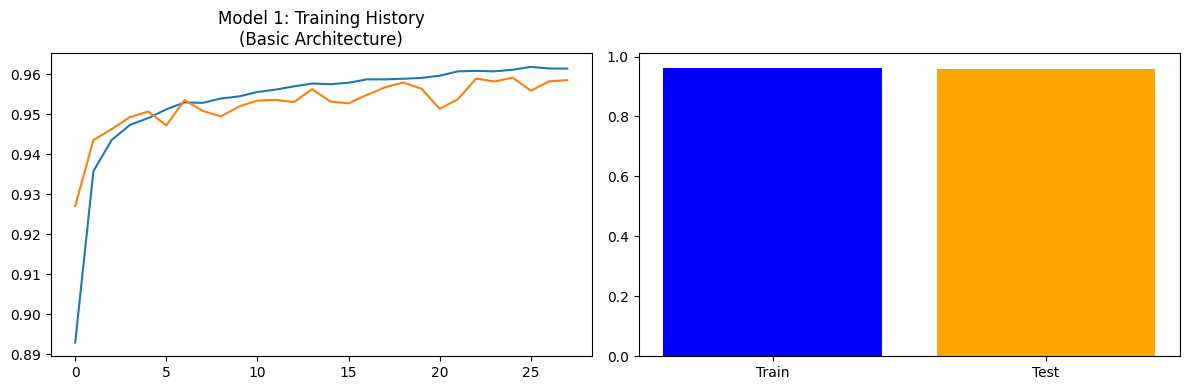

In [ ]:
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_2.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train_2, y_train_2, epochs=50, batch_size=256, validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                     verbose=1)

# Store results
train_acc1 = model1.evaluate(X_train_2, y_train_2, verbose=0)[1]
test_acc1 = model1.evaluate(X_test_2, y_test_2, verbose=0)[1]
ann_results.append({
    'arch': 'Basic (128-64-32)',
    'train_acc': train_acc1,
    'test_acc': test_acc1,
    'history': history1
})

# Plot for Model 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Model 1: Training History\n(Basic Architecture)')
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_acc1, test_acc1], color=['blue', 'orange'])
plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = model1.evaluate(X_test_2, y_test_2, verbose=0)
print(f"Test Accuracy for the test data is {test_acc:.4f}")

Test Accuracy for the test data is 0.9583


In [ ]:
y_pred = model1.predict(X_test_2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_2, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'],
    digits=4
))

4179/4179 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
              precision    recall  f1-score   support

      Cloudy     0.8949    0.9444    0.9190     33438
       Windy     0.9972    0.9994    0.9983     33507
   Clear/Dry     0.9446    0.8893    0.9161     33425
       Rainy     0.9989    1.0000    0.9995     33346

    accuracy                         0.9583    133716
   macro avg     0.9589    0.9583    0.9582    133716
weighted avg     0.9589    0.9583    0.9582    133716



### With BatchNorm & Dropout (128-64-32)

Epoch 1/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7952 - loss: 0.4913 - val_accuracy: 0.9078 - val_loss: 0.2128
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8966 - loss: 0.2369 - val_accuracy: 0.9243 - val_loss: 0.1807
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9097 - loss: 0.2087 - val_accuracy: 0.9350 - val_loss: 0.1550
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9183 - loss: 0.1907 - val_accuracy: 0.9388 - val_loss: 0.1473
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9228 - loss: 0.1779 - val_accuracy: 0.9402 - val_loss: 0.1416
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9270 - loss: 0.1694 - val_accuracy: 0.9411 - val_loss: 0.1372
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9294 - loss: 0.1636 - val_accuracy: 0.9427 - val_loss: 0.1327
Epoch 8/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9322 - loss: 0.1589 - val_accuracy: 0

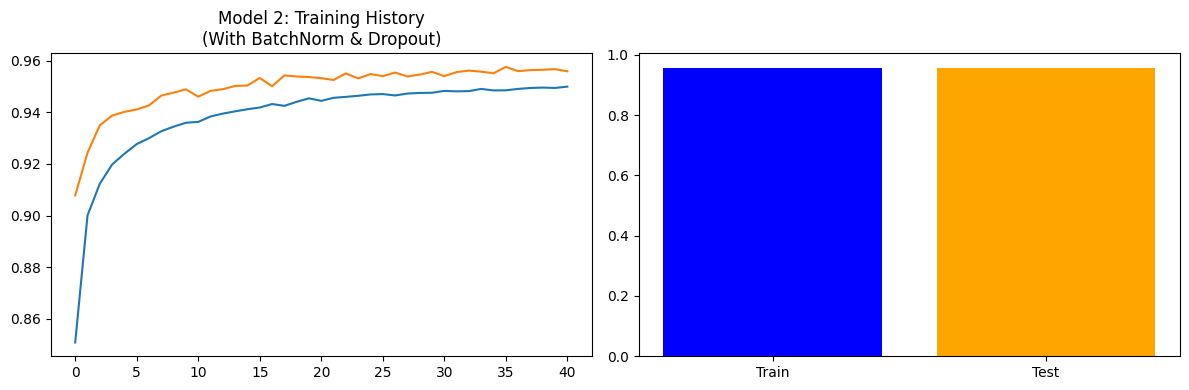

In [ ]:
model2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_2.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train_2, y_train_2, epochs=50, batch_size=256, validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                     verbose=1)

# Store results
train_acc2 = model2.evaluate(X_train_2, y_train_2, verbose=0)[1]
test_acc2 = model2.evaluate(X_test_2, y_test_2, verbose=0)[1]
ann_results.append({
    'arch': 'With BatchNorm & Dropout',
    'train_acc': train_acc2,
    'test_acc': test_acc2,
    'history': history2
})

# Plot for Model 2
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Model 2: Training History\n(With BatchNorm & Dropout)')
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_acc2, test_acc2], color=['blue', 'orange'])
plt.tight_layout()
plt.show()

In [ ]:
print(f"Train Accuracy: {train_acc2}")
print(f"Test Accuracy: {test_acc2}")

y_pred2 = model2.predict(X_test_2)
y_pred_classes = np.argmax(y_pred2, axis=1)
y_true_classes = np.argmax(y_test_2, axis=1)
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'],
    digits=4
))

Train Accuracy: 0.957436740398407
Test Accuracy: 0.956534743309021
4179/4179 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
              precision    recall  f1-score   support

      Cloudy     0.8801    0.9569    0.9169     33438
       Windy     0.9981    0.9996    0.9988     33507
   Clear/Dry     0.9553    0.8696    0.9105     33425
       Rainy     0.9991    1.0000    0.9995     33346

    accuracy                         0.9565    133716
   macro avg     0.9582    0.9565    0.9564    133716
weighted avg     0.9582    0.9565    0.9564    133716



### Smaller with BatchNorm (64-32-16)

Epoch 1/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8047 - loss: 0.4847 - val_accuracy: 0.9199 - val_loss: 0.1913
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9249 - loss: 0.1768 - val_accuracy: 0.9360 - val_loss: 0.1499
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9354 - loss: 0.1515 - val_accuracy: 0.9426 - val_loss: 0.1391
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9395 - loss: 0.1402 - val_accuracy: 0.9465 - val_loss: 0.1288
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9433 - loss: 0.1319 - val_accuracy: 0.9486 - val_loss: 0.1230
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9457 - loss: 0.1272 - val_accuracy: 0.9488 - val_loss: 0.1184
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9473 - loss: 0.1223 - val_accuracy: 0.9503 - val_loss: 0.1171
Epoch 8/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9488 - loss: 0.1183 - val_accuracy: 

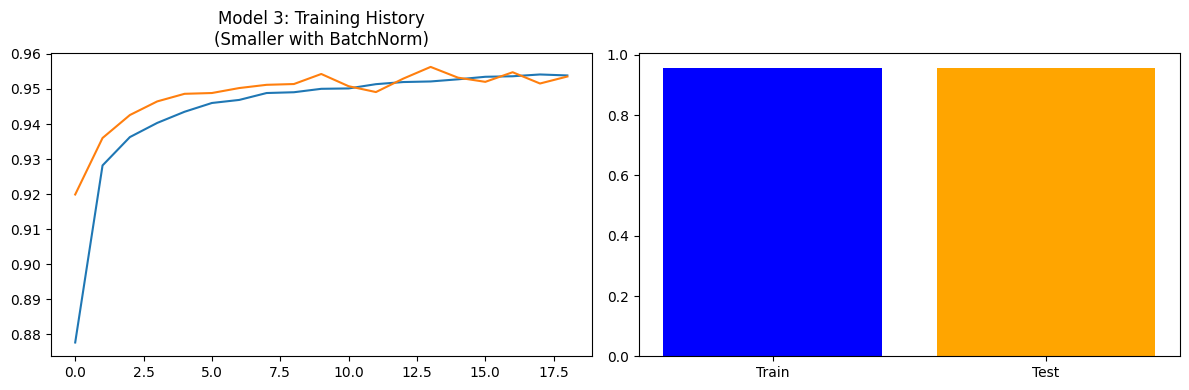

In [ ]:
model3 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_2.shape[1],)),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train_2, y_train_2, epochs=50, batch_size=256, validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                     verbose=1)

# Store results
train_acc3 = model3.evaluate(X_train_2, y_train_2, verbose=0)[1]
test_acc3 = model3.evaluate(X_test_2, y_test_2, verbose=0)[1]
ann_results.append({
    'arch': 'Smaller with BatchNorm',
    'train_acc': train_acc3,
    'test_acc': test_acc3,
    'history': history3
})

# Plot for Model 3
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.title('Model 3: Training History\n(Smaller with BatchNorm)')
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_acc3, test_acc3], color=['blue', 'orange'])
plt.tight_layout()
plt.show()

In [ ]:
print(f"Train Accuracy: {train_acc3}")
print(f"Test Accuracy: {test_acc3}")

y_pred3 = model3.predict(X_test_2)
y_pred_classes = np.argmax(y_pred3, axis=1)
y_true_classes = np.argmax(y_test_2, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'],
    digits=4
))

Train Accuracy: 0.9580300450325012
Test Accuracy: 0.955053985118866
4179/4179 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
              precision    recall  f1-score   support

      Cloudy     0.8795    0.9517    0.9142     33438
       Windy     0.9976    0.9978    0.9977     33507
   Clear/Dry     0.9501    0.8707    0.9087     33425
       Rainy     0.9988    1.0000    0.9994     33346

    accuracy                         0.9551    133716
   macro avg     0.9565    0.9551    0.9550    133716
weighted avg     0.9565    0.9551    0.9550    133716



## Finding the best model on 60:40 ratio

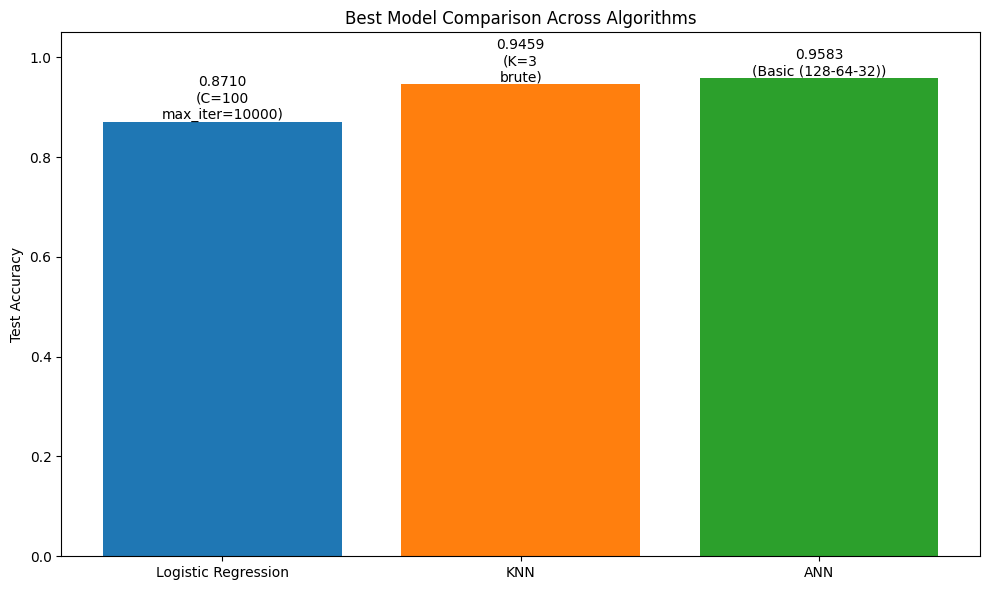

In [ ]:
best_lr = max(logistic_results, key=lambda x: x['test_acc'])
best_knn = max(knn_results, key=lambda x: x['test_acc'])
best_ann = max(ann_results, key=lambda x: x['test_acc'])

plt.figure(figsize=(10, 6))
models = ['Logistic Regression', 'KNN', 'ANN']
accuracies = [best_lr['test_acc'],best_knn['test_acc'],best_ann['test_acc']]

bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Test Accuracy')
plt.title('Best Model Comparison Across Algorithms')
plt.ylim(0, 1.05)

labels = [
    f"C={best_lr['C']}\nmax_iter={best_lr['max_iter']}",
    f"K={best_knn['n']}\n{algo}",
    best_ann['arch']
]

for bar, label in zip(bars, labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({label})',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Train Test Split Ratio (80:20)

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize data structures to store results
logistic_results = []
knn_results = []
ann_results = []

## Logistic Regression

In [ ]:
C_values = [0.01, 1, 100]
max_iters = [2000, 5000, 10000]

print("Logistic Regression Results")
for c, max_iter in zip(C_values, max_iters):
    model = LogisticRegression(multi_class='multinomial', random_state=42, C=c, max_iter=max_iter)
    model.fit(X_train_3, y_train_3)
    train_acc = model.score(X_train_3, y_train_3)
    test_pred = model.predict(X_test_3)
    test_acc = accuracy_score(y_test_3, test_pred)
    logistic_results.append({
        'C': c,
        'max_iter': max_iter,
        'train_acc': train_acc,
        'test_acc': test_acc
    })
    print(f"\nC={c}, max_iter={max_iter}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision (Macro): {precision_score(y_test_3, test_pred, average='macro'):.4f}")
    print(f"Recall (Macro):    {recall_score(y_test_3, test_pred, average='macro'):.4f}")
    print(f"F1 Score (Macro):  {f1_score(y_test_3, test_pred, average='macro'):.4f}")
    print("Classification Report",classification_report(y_test_3, test_pred))

Logistic Regression Results

C=0.01, max_iter=2000
Train Accuracy: 0.8682
Test Accuracy: 0.8686
Precision (Macro): 0.8674
Recall (Macro):    0.8680
F1 Score (Macro):  0.8677
Classification Report               precision    recall  f1-score   support

           0       0.74      0.73      0.74     16679
           1       0.98      1.00      0.99     16899
           2       0.74      0.75      0.75     16609
           3       1.00      0.99      1.00     16671

    accuracy                           0.87     66858
   macro avg       0.87      0.87      0.87     66858
weighted avg       0.87      0.87      0.87     66858


C=1, max_iter=5000
Train Accuracy: 0.8708
Test Accuracy: 0.8705
Precision (Macro): 0.8697
Recall (Macro):    0.8700
F1 Score (Macro):  0.8698
Classification Report               precision    recall  f1-score   support

           0       0.75      0.73      0.74     16679
           1       0.99      1.00      1.00     16899
           2       0.74      0.75      0.

## KNN


In [ ]:
n_neighbors_list = [3, 5, 7]
algorithms = ['ball_tree', 'kd_tree', 'brute']

print("\nKNN Classifier Results")
for n, algo in zip(n_neighbors_list, algorithms):
    model = KNeighborsClassifier(n_neighbors=n, algorithm=algo)
    model.fit(X_train_3, y_train_3)
    train_acc = model.score(X_train_3, y_train_3)
    test_pred = model.predict(X_test_3)
    test_acc = accuracy_score(y_test_3, test_pred)
    knn_results.append({
        'n': n,
        'algo': algo,
        'train_acc': train_acc,
        'test_acc': test_acc
    })
    print(f"\nK={n}, Algorithm={algo}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision (Macro): {precision_score(y_test_3, test_pred, average='macro'):.4f}")
    print(f"Recall (Macro):    {recall_score(y_test_3, test_pred, average='macro'):.4f}")
    print(f"F1 Score (Macro):  {f1_score(y_test_3, test_pred, average='macro'):.4f}")
    print("Classification Report",classification_report(y_test_3, test_pred))


KNN Classifier Results

K=3, Algorithm=ball_tree
Train Accuracy: 0.9798
Test Accuracy: 0.9529
Precision (Macro): 0.9526
Recall (Macro):    0.9527
F1 Score (Macro):  0.9525
Classification Report               precision    recall  f1-score   support

           0       0.92      0.89      0.91     16679
           1       0.99      1.00      0.99     16899
           2       0.90      0.92      0.91     16609
           3       1.00      1.00      1.00     16671

    accuracy                           0.95     66858
   macro avg       0.95      0.95      0.95     66858
weighted avg       0.95      0.95      0.95     66858


K=5, Algorithm=kd_tree
Train Accuracy: 0.9691
Test Accuracy: 0.9475
Precision (Macro): 0.9472
Recall (Macro):    0.9473
F1 Score (Macro):  0.9471
Classification Report               precision    recall  f1-score   support

           0       0.91      0.88      0.89     16679
           1       0.98      1.00      0.99     16899
           2       0.89      0.91     

## Neural Network

### Basic (128-64-32)

In [ ]:
y_train_3 = tf.keras.utils.to_categorical(y_train_3, num_classes=4)
y_test_3 = tf.keras.utils.to_categorical(y_test_3, num_classes=4)

Epoch 1/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8549 - loss: 0.3658 - val_accuracy: 0.9329 - val_loss: 0.1569
Epoch 2/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9360 - loss: 0.1514 - val_accuracy: 0.9327 - val_loss: 0.1503
Epoch 3/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9451 - loss: 0.1293 - val_accuracy: 0.9490 - val_loss: 0.1227
Epoch 4/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9501 - loss: 0.1177 - val_accuracy: 0.9548 - val_loss: 0.1099
Epoch 5/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9509 - loss: 0.1152 - val_accuracy: 0.9539 - val_loss: 0.1093
Epoch 6/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9536 - loss: 0.1093 - val_accuracy: 0.9481 - val_loss: 0.1254
Epoch 7/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9546 - loss: 0.1071 - val_accuracy: 0.9537 - val_loss: 0.1114
Epoch 8/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9558 - loss: 0.1040 - val_accuracy: 0.

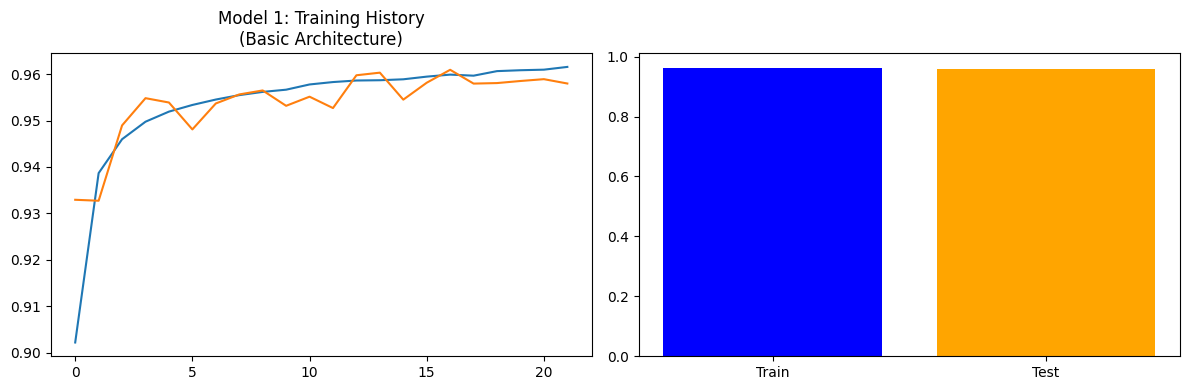

In [ ]:
model4 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_3.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(X_train_3, y_train_3, epochs=50, batch_size=256, validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                     verbose=1)

# Store results
train_acc4 = model4.evaluate(X_train_3, y_train_3, verbose=0)[1]
test_acc4 = model4.evaluate(X_test_3, y_test_3, verbose=0)[1]
ann_results.append({
    'arch': 'Basic (128-64-32)',
    'train_acc': train_acc4,
    'test_acc': test_acc4,
    'history': history4
})

# Plot for Model 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train')
plt.plot(history4.history['val_accuracy'], label='Validation')
plt.title('Model 1: Training History\n(Basic Architecture)')
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_acc4, test_acc4], color=['blue', 'orange'])
plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = model4.evaluate(X_test_3, y_test_3, verbose=0)
print(f"Test Accuracy for the test data is {test_acc:.2f}")

Test Accuracy for the test data is 0.96


In [ ]:
y_pred = model4.predict(X_test_3)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_3, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'],
    digits=4
))

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

      Cloudy     0.8945    0.9459    0.9195     16679
       Windy     0.9982    0.9989    0.9986     16899
   Clear/Dry     0.9445    0.8889    0.9159     16609
       Rainy     0.9994    1.0000    0.9997     16671

    accuracy                         0.9586     66858
   macro avg     0.9592    0.9584    0.9584     66858
weighted avg     0.9593    0.9586    0.9586     66858



### With BatchNorm & Dropout (128-64-32)

Epoch 1/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8090 - loss: 0.4531 - val_accuracy: 0.9124 - val_loss: 0.2004
Epoch 2/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9001 - loss: 0.2313 - val_accuracy: 0.9254 - val_loss: 0.1727
Epoch 3/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9157 - loss: 0.1964 - val_accuracy: 0.9383 - val_loss: 0.1463
Epoch 4/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9217 - loss: 0.1795 - val_accuracy: 0.9435 - val_loss: 0.1372
Epoch 5/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9283 - loss: 0.1671 - val_accuracy: 0.9431 - val_loss: 0.1345
Epoch 6/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9304 - loss: 0.1613 - val_accuracy: 0.9473 - val_loss: 0.1271
Epoch 7/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9355 - loss: 0.1518 - val_accuracy: 0.9473 - val_loss: 0.1245
Epoch 8/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9368 - loss: 0.1468 - val_accuracy: 0

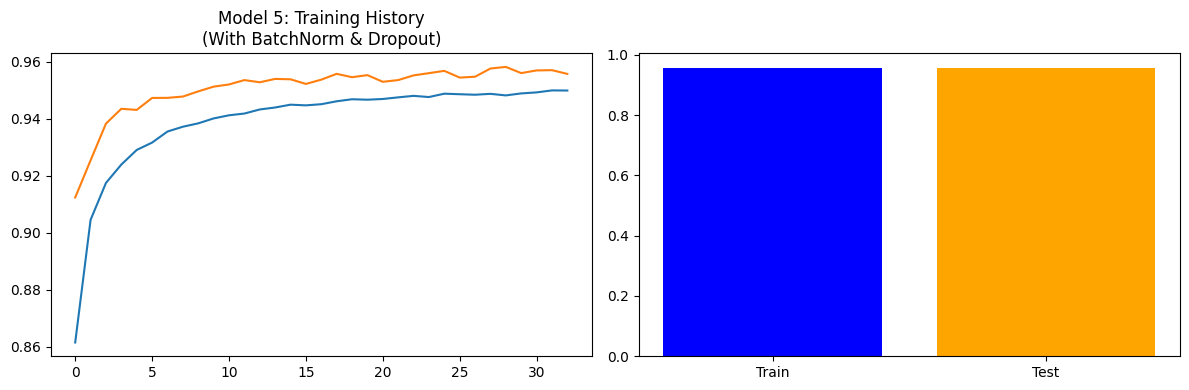

In [ ]:
model5 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_3.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation='softmax')
])
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history5 = model5.fit(X_train_3, y_train_3, epochs=50, batch_size=256, validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                     verbose=1)

# Store results
train_acc5 = model5.evaluate(X_train_3, y_train_3, verbose=0)[1]
test_acc5 = model5.evaluate(X_test_3, y_test_3, verbose=0)[1]
ann_results.append({
    'arch': 'With BatchNorm & Dropout',
    'train_acc': train_acc5,
    'test_acc': test_acc5,
    'history': history5
})

# Plot for Model 2
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Train')
plt.plot(history5.history['val_accuracy'], label='Validation')
plt.title('Model 5: Training History\n(With BatchNorm & Dropout)')
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_acc5, test_acc5], color=['blue', 'orange'])
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model5.evaluate(X_test_3, y_test_3, verbose=0)
print(f"Test Accuracyfor the test data is {test_acc:.4f}")

y_pred2 = model5.predict(X_test_3)
y_pred_classes = np.argmax(y_pred2, axis=1)
y_true_classes = np.argmax(y_test_3, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'],
    digits=4
))

Test Accuracyfor the test data is 0.9560
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

      Cloudy     0.8826    0.9505    0.9153     16679
       Windy     0.9980    0.9995    0.9987     16899
   Clear/Dry     0.9485    0.8731    0.9092     16609
       Rainy     0.9993    1.0000    0.9997     16671

    accuracy                         0.9560     66858
   macro avg     0.9571    0.9558    0.9557     66858
weighted avg     0.9572    0.9560    0.9559     66858



### Smaller with BatchNorm (64-32-16)

Epoch 1/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8444 - loss: 0.3931 - val_accuracy: 0.9327 - val_loss: 0.1632
Epoch 2/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9301 - loss: 0.1633 - val_accuracy: 0.9445 - val_loss: 0.1335
Epoch 3/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9405 - loss: 0.1406 - val_accuracy: 0.9474 - val_loss: 0.1270
Epoch 4/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9443 - loss: 0.1308 - val_accuracy: 0.9446 - val_loss: 0.1250
Epoch 5/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9463 - loss: 0.1260 - val_accuracy: 0.9519 - val_loss: 0.1151
Epoch 6/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9480 - loss: 0.1227 - val_accuracy: 0.9488 - val_loss: 0.1255
Epoch 7/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9498 - loss: 0.1185 - val_accuracy: 0.9536 - val_loss: 0.1110
Epoch 8/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9500 - loss: 0.1173 - val_accuracy: 0.

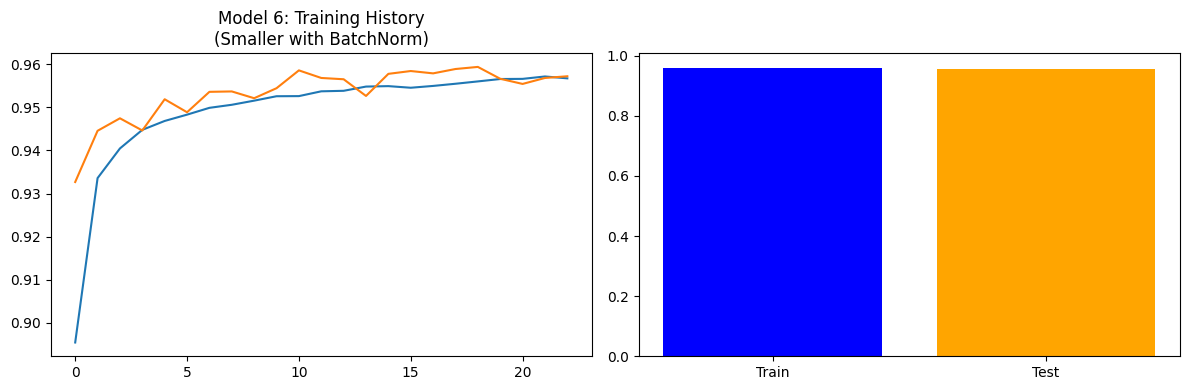

In [ ]:
model6 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_3.shape[1],)),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
])
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history6 = model6.fit(X_train_3, y_train_3, epochs=50, batch_size=256, validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                     verbose=1)

# Store results
train_acc6 = model6.evaluate(X_train_3, y_train_3, verbose=0)[1]
test_acc6 = model6.evaluate(X_test_3, y_test_3, verbose=0)[1]
ann_results.append({
    'arch': 'Smaller with BatchNorm',
    'train_acc': train_acc6,
    'test_acc': test_acc6,
    'history': history6
})

# Plot for Model 3
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Train')
plt.plot(history6.history['val_accuracy'], label='Validation')
plt.title('Model 6: Training History\n(Smaller with BatchNorm)')
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_acc6, test_acc6], color=['blue', 'orange'])
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model6.evaluate(X_test_3, y_test_3, verbose=0)
print(f"Test Accuracyfor the test data is {test_acc:.4f}")

y_pred3 = model6.predict(X_test_3)
y_pred_classes = np.argmax(y_pred3, axis=1)
y_true_classes = np.argmax(y_test_3, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Cloudy', 'Windy', 'Clear/Dry', 'Rainy'],
    digits=4
))

Test Accuracyfor the test data is 0.9561
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

      Cloudy     0.8870    0.9450    0.9151     16679
       Windy     0.9978    0.9986    0.9982     16899
   Clear/Dry     0.9433    0.8798    0.9104     16609
       Rainy     0.9992    1.0000    0.9996     16671

    accuracy                         0.9561     66858
   macro avg     0.9568    0.9558    0.9558     66858
weighted avg     0.9570    0.9561    0.9560     66858



## Comparing all models on 80:20 ratio

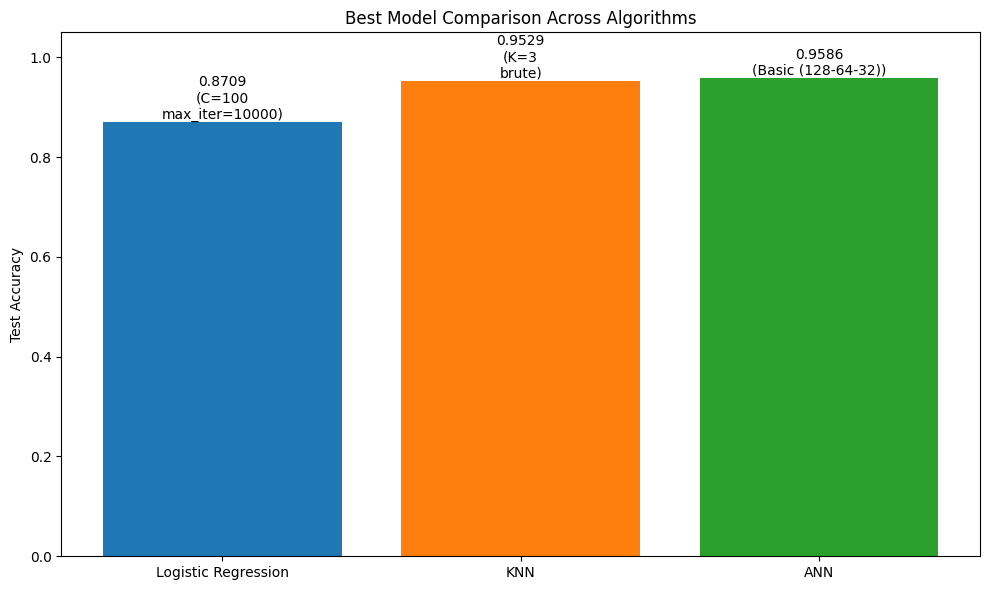

In [ ]:
best_lr = max(logistic_results, key=lambda x: x['test_acc'])
best_knn = max(knn_results, key=lambda x: x['test_acc'])
best_ann = max(ann_results, key=lambda x: x['test_acc'])

plt.figure(figsize=(10, 6))
models = ['Logistic Regression', 'KNN', 'ANN']
accuracies = [best_lr['test_acc'],best_knn['test_acc'],best_ann['test_acc']]

bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Test Accuracy')
plt.title('Best Model Comparison Across Algorithms')
plt.ylim(0, 1.05)

labels = [
    f"C={best_lr['C']}\nmax_iter={best_lr['max_iter']}",
    f"K={best_knn['n']}\n{algo}",
    best_ann['arch']
]

for bar, label in zip(bars, labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({label})',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()